## Fehlerdetektion durch Anomalieerkennung in Zeitreihen

Ein parametrisches Modell eignet sich auch, um recht einfache Algorithmen zur Fehler- oder Anomaliedetektion in technischen Prozessen zu realisieren.

Grundlage ist die Modellvorstellung, dass der technische Prozess am Ausgang im Nominalfall eine Zeitreihe erzeugt, die sich durch einen AR-Prozess modellieren läßt. Im Anomalie- oder Schadensfall wird dieses Verhalten modifiziert, was entweder durch Veränderung des AR-Prozesses oder Überlagerung mit einem weiteren Prozess modelliert wird.

- Zunächst wird eine Zeitreihe eines Sensorsignals im Nominalzustand, z.B. an einer ungeschädigten Maschine aufgenommen
- Daraus wird ein AR Modell ermittelt. 
- Nach erfolgter Identifikation der AR-Parameter werden laufend weitere Werte $y(k)$ der Zeitreihe aufgenommen und der Prädiktionsfehler $e(k)$ des Modells ermittelt:
  $ e(k) = y(k) - \sum_{n=1}^{N}{d(n) y(k-n)}$
- Annahme ist, dass ein Fehler oder Schaden zu einer Änderung der Parameter der Zeitreihe führt. War im Nominalfall idealerweise der Fehler nur ein weisses Rauschen, weil alle korrelierten Bestandteile im Modell erfasst wurden, ist dies beim Anomaliefall nicht mehr gegeben:
- $e(k)$ wird korrelierte Bestandteile enthalten, was man durch die Analyse der Autokorrelation des Signals einfach herausfinden kann. Zur weiteren Diagnose könnte an dieser Stelle ein neues Modell geschätzt werden.


Umsetzung eines einfachen Beispiels: Das Nominalverhalten wird durch eine Zeitreihe dargestellt, die von einem AR Modell (angeregt durch weisses Rauschen) erzeugt wird. Das Fehlerverhalten wird durch ein verändertes Systemverhalten (AR Parameter) modelliert.

In Anlehnung an einen vergangenen IAEA Benchmark: Eine Kraftwerksanlage erzeugt im Nominalbetrieb ein bestimmtes Körperschallsignal, z.B. durch die Schwingungen in Kesseln und Rohrleitungen. Leckagen oder ungewollte Reaktionen werden das Systemverhalten modifizieren, und zu veränderten Signalen führen.

In [1]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d
import scipy.signal as sp
import numpy as np
from spectrum import *
%matplotlib inline

Definition des Nominalverhaltens des Systems. Hier wird ein einfaches AR(2) Systemverhalten angenommen, welches von weissem Rauschen angeregt wird. Aus den beiden konjugiert komplexen Polstellen wird das charakteristische Polynom berechnet:
$(1-p_1 q)(1 - p_1^* q) = 1 - q 2 Re{p_1} + q^2 |p_1|^2$  

In [2]:
# Definition eines konjugiert komplexen Polpaars in der z-Ebene. 
p1 = 0.7 + 0.45j
b1 = 2.0 * np.real(p1)
b2 = np.abs(p1)**2

### Simulation zur Erzeugung einer Zeitreihe des Nominalverhaltens
Der Vergleich mit dem Eingangssignal, das im Weiteren als unbekannt vorausgesetzt wird, zeigt deutlich die filternde Wirkung des AR(2) Prozesses.

In [3]:
# Länge der Zeitreihe
tsim = 400
t = range(tsim)
# Erzeugung eines weissen Rauschens als Eingangssignals
v = np.random.normal(0,0.1,size=tsim)
# leere Vektoren anlegen
y = np.zeros(tsim)
# Berechnung der Zeitreihe des Ausgangssignals
for k in range(2,tsim,1):
    y[k] = v[k] + b1*y[k-1] - b2*y[k-2]

Text(0, 0.5, 'y(k)')

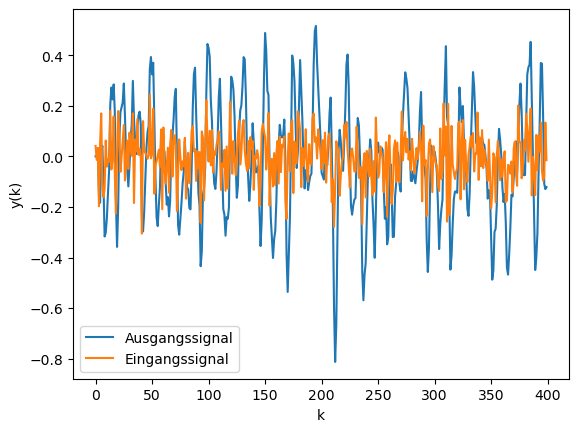

In [4]:
plt.style.use('default')
plt.figure()
plt.plot(t, y, label = "Ausgangssignal")
plt.plot(t, v, label = "Eingangssignal")
plt.legend()
plt.xlabel("k")
plt.ylabel("y(k)")

Schätzung eines AR(2)-Modells für den Nominalzustand


In [5]:
# Aufbau der Regressionsmatrix und des Vektors für die rechte Seite
phi = np.zeros((len(y),2))
u = np.zeros((len(y),1))
 
for i in range(2,len(y)): # Auftellen des Gleichungssystemes: p[0]= a,p[1]= b
    phi[i,0] = y[i-1]
    phi[i,1] = y[i-2]
    u[i,0] = y[i]
  
AR, residuals, rank, s = np.linalg.lstsq(phi,u,-1)

#AR = -AR

Berechnung der Zeitreihe des Prädiktionsfehlers $e(k) = y(k) - \hat{b}_1 y(k-1) - \hat{b}_2 y(k-2)$

In [6]:
e = np.zeros_like(y)
for k in range(2,tsim,1):
    e[k] = y[k] - AR[0,0]*y[k-1] - AR[1,0]*y[k-2]

Text(0, 0.5, 'e(k), v(k)')

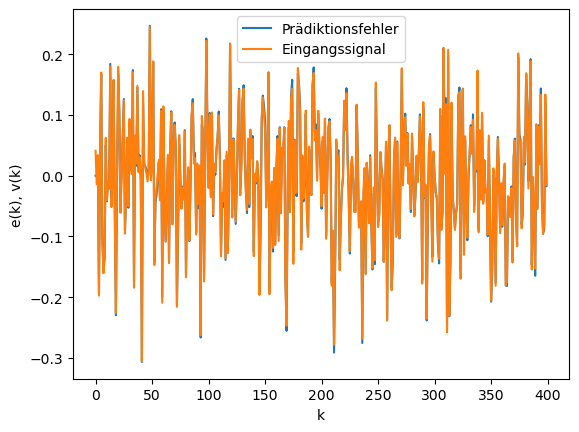

In [7]:
plt.figure()
plt.plot(t, e, label = "Prädiktionsfehler")
plt.plot(t, v, label = "Eingangssignal")
plt.legend()
plt.xlabel("k")
plt.ylabel("e(k), v(k)")

Wie erwartet entspricht der Prädiktionsfehler dem Eingangssignal. 

Der Prädiktionsfehler ist daher weisses Rauschen, dessen Autokovarianzfunktion für alle $k \neq 1$ verschwindet. Zur Probe werden die AKF berechnet. Allerdings wird nicht - wie es bei einem zeitinvarianten System hilfreich wäre - über die einzelnen berechneten Funktionen gemittelt, um bei einem späteren Einsatz zur Fehlerdetektion Veränderungen in der AKF finden zu können.

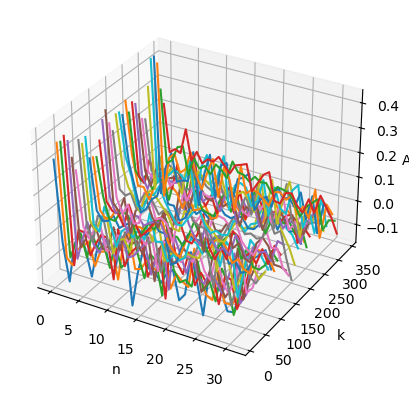

In [8]:
# Länge der AKF bzw. des Blocks der Zeitreihe
l_AKF = 32

k = 0
plt.style.use('default')
ax = plt.axes(projection='3d')
while k+2*l_AKF<tsim:
    AKF = np.zeros(l_AKF)
    for n in range(0,l_AKF):
        AKF[n] = np.dot(e[k:k+l_AKF],e[k+n:k+l_AKF+n])
    k = k + 10
    plt.plot(range(0,l_AKF) ,k, AKF)
    
ax.set_xlabel("n")
ax.set_ylabel("k")
ax.set_zlabel("AKF")
ax.view_init(elev=30, azim=-60, roll=0)

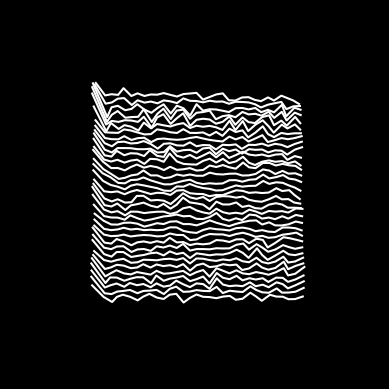

In [9]:
plt.style.use('dark_background')
fig = plt.figure( )
ax = plt.axes(projection='3d',facecolor = "k")
k = 0
while k+2*l_AKF<tsim:
    AKF = np.zeros(l_AKF)
    for n in range(0,l_AKF):
        AKF[n] = np.dot(e[k:k+l_AKF],e[k+n:k+l_AKF+n])
    k = k + 10
    plt.plot(range(0,l_AKF) ,k, AKF,"w")

ax.grid(False)
ax.xaxis.pane.fill = False
ax.yaxis.pane.fill = False
ax.zaxis.pane.fill = False
ax.set_axis_off()

plt.xlabel("k")
plt.ylabel("n")
ax.view_init(elev=80, azim=-90, roll=0)

Ohne weitere Mittelwertbildung ist die geschätzte AKF mit größeren Ungenauigkeiten behaftet. Es zeigt sich aber, dass der Wert für $k=0$ deutlich größer ist als die folgenden.

### Erzeugung einer Anomalie durch Überlagerung einer weiteren Zeitreihe

Sehr vereinfacht soll als Fehlerzustand angenommen werden, dass eine starke Schwingung im Zeitsignal auftritt. Dies kann ebenfalls durch einen AR(2)-Prozess modelliert werden, allerdings mit einem Pol nahe am Einheitskreis.

In [10]:
p_A = 0.99*exp(np.pi*0.5*0.9j)
# Definition eines konjugiert komplexen Polpaars in der z-Ebene. 
b1_A = 2.0 * np.real(p_A)
b2_A = np.abs(p_A)**2

In [11]:
# Länge der Zeitreihe für den Fehlerfall
t_A_sim = 50
t_A = range(t_A_sim)
# Erzeugung eines weissen Rauschens als Eingangssignals
v_A = np.random.normal(0,0.06,size=t_A_sim)
# leere Vektoren anlegen
y_A = np.zeros(t_A_sim)
# Berechnung der Zeitreihe des Ausgangssignals
for k in range(2,t_A_sim,1):
    y_A[k] = v_A[k] + b1_A*y_A[k-1] - b2_A*y_A[k-2]

Text(0, 0.5, 'y_A(k)')

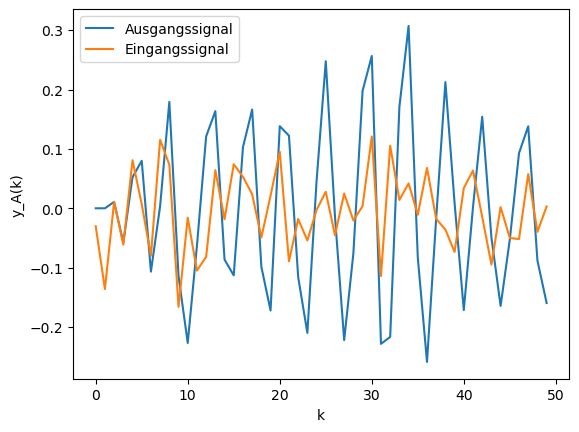

In [12]:
plt.style.use('default')
plt.figure()
plt.plot(t_A, y_A, label = "Ausgangssignal")
plt.plot(t_A, v_A, label = "Eingangssignal")
plt.legend()
plt.xlabel("k")
plt.ylabel("y_A(k)")

Erzeugung einer Anomalie: Verändertes Systemverhalten überlagern.

In [13]:
t_start = 74
y_2 = np.copy(y)
y_2[t_start:t_start + t_A_sim] =  y_2[t_start:t_start + t_A_sim] + 1 * y_A

Text(0, 0.5, 'y(k)')

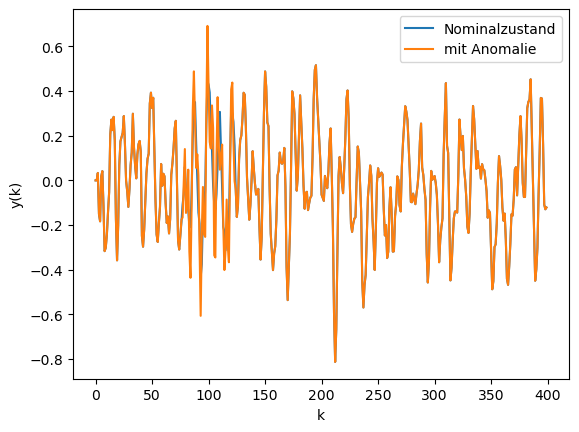

In [14]:
plt.figure()
plt.plot(t, y, label = "Nominalzustand")
plt.plot(t, y_2, label = "mit Anomalie")
plt.legend()
plt.xlabel("k")
plt.ylabel("y(k)")

Erneut wird der Prädiktionsfehler berechnet

In [15]:
e_2 = np.zeros_like(y)
for k in range(2,tsim,1):
    e_2[k] = y_2[k] - AR[0,0]*y_2[k-1] - AR[1,0]*y_2[k-2]

Text(0, 0.5, 'e(k), v(k)')

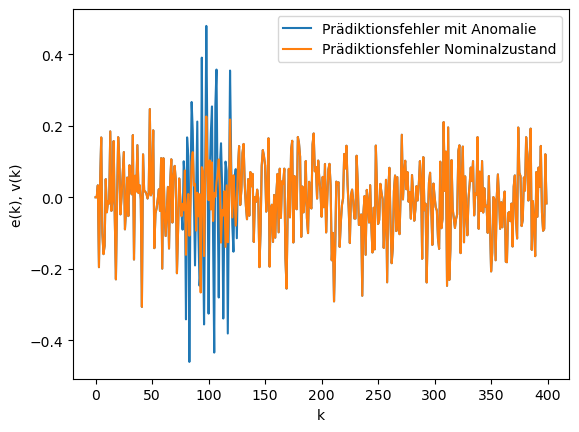

In [16]:
plt.figure()
plt.plot(t, e_2, label = "Prädiktionsfehler mit Anomalie")
plt.plot(t, e, label = "Prädiktionsfehler Nominalzustand")
plt.legend()
plt.xlabel("k")
plt.ylabel("e(k), v(k)")

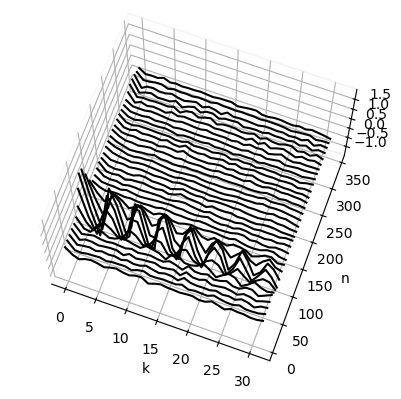

In [17]:
# Länge der AKF bzw. des Blocks der Zeitreihe

k = 0

fig = plt.figure() 
ax = plt.axes(projection='3d')
while k+2*l_AKF<tsim:
    AKF_2 = np.zeros(l_AKF)
    for n in range(0,l_AKF):
        AKF_2[n] = np.dot(e_2[k:k+l_AKF],e_2[k+n:k+l_AKF+n])
    k = k + 10
    plt.plot(range(0,l_AKF) ,k, AKF_2, "k")

plt.xlabel("k")
plt.ylabel("n")
ax.xaxis.pane.fill = False
ax.yaxis.pane.fill = False
ax.zaxis.pane.fill = False
ax.view_init(elev=70, azim=-70, roll=0)

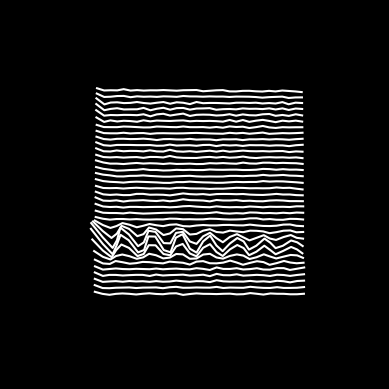

In [18]:
# 3D Plot, Unknown Pleasure style

# Länge der AKF bzw. des Blocks der Zeitreihe

k = 0

plt.style.use('dark_background')
fig = plt.figure( )
ax = plt.axes(projection='3d',facecolor = "k")
while k+2*l_AKF<tsim:
    AKF_2 = np.zeros(l_AKF)
    for n in range(0,l_AKF):
        AKF_2[n] = np.dot(e_2[k:k+l_AKF],e_2[k+n:k+l_AKF+n])
    k = k + 10
    plt.plot(range(0,l_AKF) ,k, AKF_2,"w")

ax.grid(False)
ax.xaxis.pane.fill = False
ax.yaxis.pane.fill = False
ax.zaxis.pane.fill = False
ax.set_axis_off()

plt.xlabel("k")
plt.ylabel("n")
ax.view_init(elev=80, azim=-90, roll=0)